# Datathon #4 - Clustering, Dimensionality Reduction, and Classification

In [1]:
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.cluster as skc
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

For this datathon we'll be working with data about LEGO construction sets. 

LEGO data comes from Rebrickable (https://rebrickable.com/downloads)
We're using a subset of the Rebrickable database for sets released up to mid-2017. 

We're giving you two simplified versions of the larger dataset.

**(File 1) LEGO Colors** — Contains data on all of the different colors of LEGO pieces ever released. 
- Unique pieces = How many different kinds of bricks have been produced in the color.
- Unique sets = How many different LEGO sets have included bricks in the color.
- Unique themes = How many different LEGO themes ("Town", "Space", "Ninjago", "Harry Potter", etc.) have included the color.
- Number of years = How many years have had sets with the color.
- Max set size = How big was the biggest set that includes the color. 
- Median set size = How big was the median set that includes the color.

In [3]:
lego_colors = pd.read_csv("https://drive.google.com/uc?export=download&id=1kDzl7la0-GgnQb-ry6D_S3BmB3mGJk-m",delimiter="\t")
lego_colors.head(5)

,Color,Number of Unique Pieces,Number of Unique Sets,Number of Unique Themes,Number of Years,Max Set Size,Median Set Size
0,Aqua,55,48,15,10,1305,73
1,Black,4367,8333,373,60,5922,330
2,Blue,1822,5279,342,65,5922,300
3,Blue-Violet,35,17,3,2,987,165
4,Bright Green,257,726,131,24,5200,155


In [4]:
# A few useful subsets
colors = lego_colors["Color"]
lego_colors_vals_only = lego_colors.drop(["Color"], axis=1)

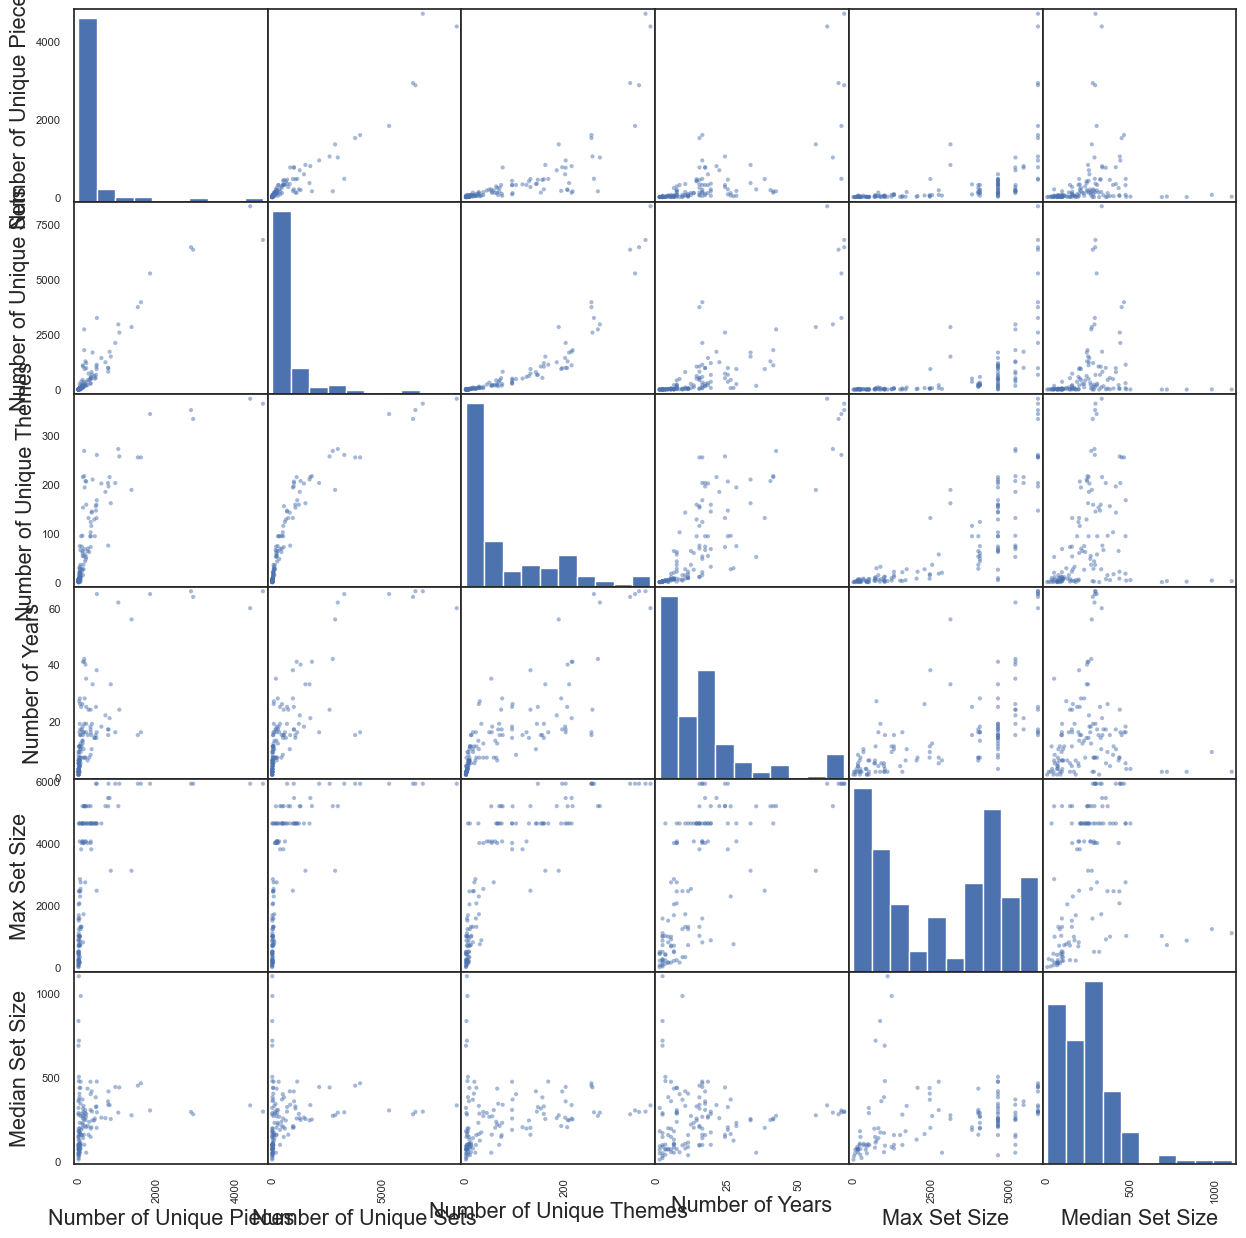

In [5]:
_ = pd.plotting.scatter_matrix(lego_colors, figsize=(15,15))

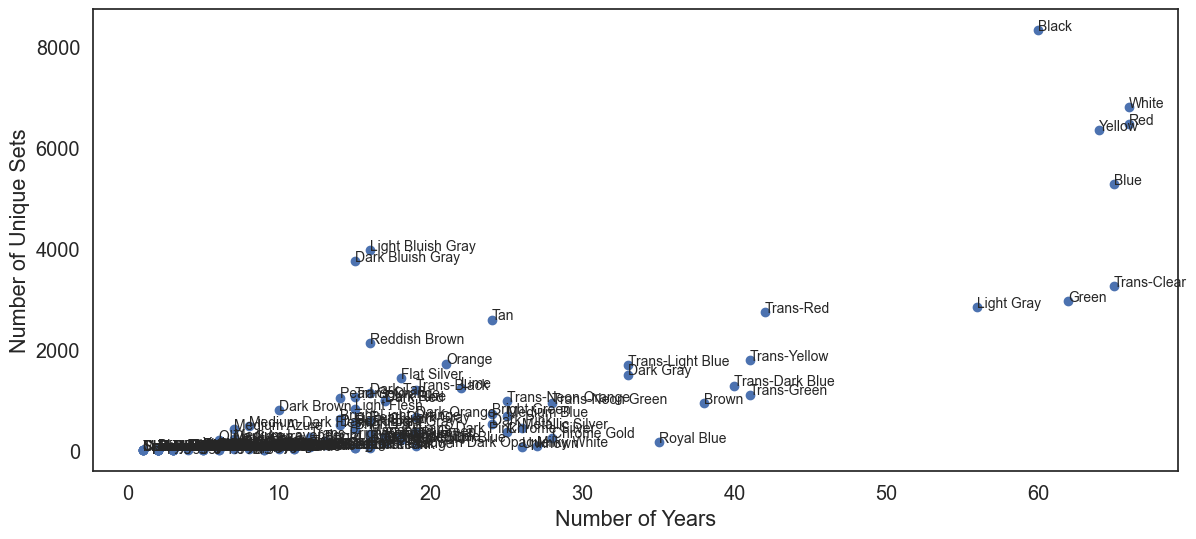

In [6]:
# A quick plot of all the colors based on number of sets and years
plt.figure(figsize=(14,6))
plt.scatter(lego_colors["Number of Years"], lego_colors["Number of Unique Sets"])
plt.xlabel('Number of Years')
plt.ylabel('Number of Unique Sets')

for i, row in enumerate(lego_colors.values):
    plt.annotate(row[0],xy=(row[4],row[2]),fontsize=10)

**(File 2) LEGO Colors by Set** — Contains data on the colors of the pieces in each LEGO set.

- Set Num = A unique alphanumeric ID number for each set. 
- Set Name = The official name of the set (some names are reused for more than one set).
- Year = The year the set was released.
- Num Parts = Total number of parts listed on the box.
- Theme = The theme the set was released under ("Technic", "Ninjago", "Star Wars", "City", etc.)
- [Colors] = Number of parts of each color in the set, according to the Rebrickable database.

You can also get more data about individual sets by going to http://rebrickable.com/sets/{SetNum}

In [4]:
# Import data, remove NaN
lego_colors_by_set_full = pd.read_excel('https://drive.google.com/uc?export=download&id=1EppL5Cy4YSND45x--HV3yKavszTu2ALB')
lego_colors_by_set_full.fillna(0, inplace=True)

# For this datathon we'll just focus on 10 of the most popular themes.
lego_colors_by_set = lego_colors_by_set_full[(lego_colors_by_set_full["Theme"] == "Technic") |
                        (lego_colors_by_set_full["Theme"] == "Friends") |
                        (lego_colors_by_set_full["Theme"] == "City") |
                        (lego_colors_by_set_full["Theme"] == "Basic Set") |
                        (lego_colors_by_set_full["Theme"] == "Creator") |
                        (lego_colors_by_set_full["Theme"] == "Duplo") |
                        (lego_colors_by_set_full["Theme"] == "Star Wars") |
                        (lego_colors_by_set_full["Theme"] == "Ninjago") |
                        (lego_colors_by_set_full["Theme"] == "Construction") |
                        (lego_colors_by_set_full["Theme"] == "Airport")]

In [7]:
lego_colors_by_set.head(3)

,Set Num,Set Name,Theme,Year,Num Parts,[No Color],Aqua,Black,Blue,Blue-Violet,...,Trans-Very Lt Blue,Trans-Yellow,Unknown,Very Light Bluish Gray,Very Light Gray,Very Light Orange,Violet,White,Yellow,Yellowish Green
4,2823692,Simple and Motorized Machines Activity Pack,Technic,1997,24,24.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2818944,Structures Set,Technic,1997,439,20.0,0.0,116.0,56.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2814926,Technology Activity Set,Technic,1994,318,17.0,0.0,92.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0


Some potentially useful refactorings of the data.

In [5]:
# Creates a copy of the dataframe where color counts are normalized 
#  so each gives the % of parts in the set with that color, rather than the total count.
lego_colors_by_set_norm = lego_colors_by_set.copy()
lego_colors_by_set_norm = lego_colors_by_set_norm.drop([ 'Set Name', 'Set Num', 'Theme', 'Year', 'Num Parts'], axis=1)
lego_colors_by_set_norm = lego_colors_by_set_norm.div(lego_colors_by_set_norm.sum(axis=1), axis=0)

# A list of all the color name columns
color_cols = lego_colors_by_set_norm.columns
# A list of all the other numeric columns
other_cols = ["Year", "Num Parts"]

# Add back the non-numeric columns to the normalized table
lego_colors_by_set_norm["Year"] = lego_colors_by_set["Year"]
lego_colors_by_set_norm["Set Name"] = lego_colors_by_set["Set Name"]
lego_colors_by_set_norm["Set Num"] = lego_colors_by_set["Set Num"]
lego_colors_by_set_norm["Theme"] = lego_colors_by_set["Theme"]
lego_colors_by_set_norm["Num Parts"] = lego_colors_by_set["Num Parts"]
lego_colors_by_set_norm.head(3)

,[No Color],Aqua,Black,Blue,Blue-Violet,Bright Green,Bright Light Blue,Bright Light Orange,Bright Light Yellow,Bright Pink,...,Very Light Orange,Violet,White,Yellow,Yellowish Green,Year,Set Name,Set Num,Theme,Num Parts
4,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1997,Simple and Motorized Machines Activity Pack,2823692,Technic,24
8,0.045558,0.0,0.264237,0.127563,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1997,Structures Set,2818944,Technic,439
10,0.051360,0.0,0.277946,0.006042,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.006042,0.003021,0.0,1994,Technology Activity Set,2814926,Technic,318


In [6]:
color_cols # The complete list of color columns

Index(['[No Color]', 'Aqua', 'Black', 'Blue', 'Blue-Violet', 'Bright Green',
       'Bright Light Blue', 'Bright Light Orange', 'Bright Light Yellow',
       'Bright Pink',
       ...
       'Trans-Very Lt Blue', 'Trans-Yellow', 'Unknown',
       'Very Light Bluish Gray', 'Very Light Gray', 'Very Light Orange',
       'Violet', 'White', 'Yellow', 'Yellowish Green'],
      dtype='object', length=131)

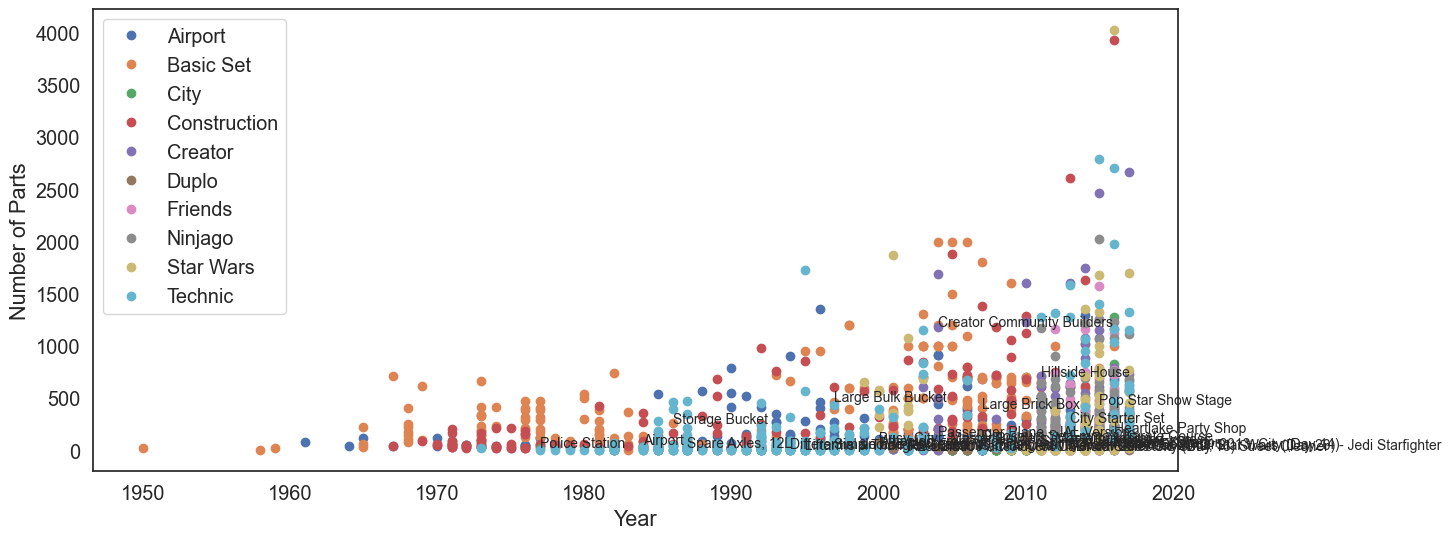

In [7]:
# A quick plot of all the sets in our reduced dataset by number of parts and year
themes = lego_colors_by_set.groupby("Theme")
plt.figure(figsize=(14,6))
plt.xlabel('Year')
plt.ylabel('Number of Parts')

for theme, group in themes: # iterate and plot sets by theme for colors
    plt.plot(group["Year"], group["Num Parts"], marker="o", linestyle="", label=theme)
    for i, row in enumerate(group.values[0::100]): #add labels on every 100th set
        plt.annotate(row[1],xy=(row[3],row[4]),fontsize=10)

_ = plt.legend()



Remember that you can always export results to a CSV to examine them elsewhere (for example in Tableau).

In [8]:
lego_colors_by_set.to_csv("data/lego_dataframe_export.csv")

## Questions

***Using File 1 (Lego Colors Data):***
1. Use *principle component analysis (PCA)* to find a projection that reveals groups of colors that have similar characteristics. What set of data columns and set of principle components do you think show the clearest result? 
2. Use *hierarchical clustering* to find groups of colors that have similar characteristics. What set of data columns, distance metric, linkage function, and distance threshold do you think give the best result?
3. Use *k-means* clustering to find groups of colors that have similar characteristics. What set of data columns and what value of k do you think gives the best result? 

***Using File 2 (Set Color Data):***

4. Train and test (**a**) a *kNN* classifier and (**b**) a *Naïve Bayes* classifier to predict the theme for new Lego kits based on the data about them.
    * For each classifier, report:
        * What parameters (if any) you tuned.
        * How well it performed. — Report the Accuracy, Precision, Recall, and F1-score. Also render a confusion matrix. (Remember, don’t test on your training data!)
        * Your interpretation of the result. Explain what you think the classifier got right/wrong. (Feel free to include visualizations or additional info that helps explain).

... + 1 more analysis questions of your own using either File 1 (Lego Colors) or File 2 (Lego Colors by Set) and the tool(s) of your choice.

## Answers

In [33]:
# Read colors data
colors_ref = pd.read_csv("/Users/berg/DataspellProjects/MDSA-UofC/DATA605/04_datathon/data/colors_processed_v2.csv")
# Check if 'name' in colors_ref is same as 'Colors' in lego_colors
# Convert to lists
colors_ref_list = colors_ref['name'].tolist()
lego_colors_list = color_cols.tolist()
# Check what colors are in lego_colors but not in colors_ref
colors_not_in_ref = [x for x in lego_colors_list if x not in colors_ref_list]
# Check what colors are in colors_ref but not in lego_colors
colors_not_in_lego = [x for x in colors_ref_list if x not in lego_colors_list]
# Drop rows in colors_ref that are not in lego_colors
colors_ref = colors_ref[colors_ref['name'].isin(lego_colors_list)]


In [34]:
# Convert 'r', 'g', 'b' columns in colors_ref to numpy array
colors_ref_np = colors_ref[['r', 'g', 'b']].to_numpy()
# Normalize colors_ref_np
colors_ref_np = colors_ref_np / 255


In [35]:
import colorsys

colors_ref_np_sorted = sorted(colors_ref_np, key=lambda rgb: colorsys.rgb_to_hls(*rgb))
# Convert colors_ref_np_sorted to numpy array
colors_ref_np_sorted = np.array(colors_ref_np_sorted)
# Use the same function from colorsys to sort the colors in colors_ref dataframe
colors_ref['hls'] = colors_ref.apply(lambda row: colorsys.rgb_to_hls(row['r']/255, row['g']/255, row['b']/255), axis=1)
# Sort colors_ref by 'hls' column
colors_ref = colors_ref.sort_values(by=['hls'])
# Reset index
colors_ref = colors_ref.reset_index(drop=True)

In [12]:
# Split colors_ref into groups of 7 with cutoff index 3, 9, 14, 49, 74, 112
colors_ref_groups = np.split(colors_ref, [3, 9, 14, 49, 74, 112])
# Create a list of colors for each group
colors_ref_groups_list = ['b', 'w', 'r', 'y', 'g', 'o', 'p']
# Add a new column 'family_color' to colors_ref_groups
for i, group in enumerate(colors_ref_groups):
    group['family_color'] = colors_ref_groups_list[i]
# Join colors_ref_groups back into one dataframe
colors_ref = pd.concat(colors_ref_groups)
# select only the columns we need 'name', 'family_color'
colors_ref = colors_ref[['name', 'family_color']]

In [13]:
lego_colors_by_set_copy = lego_colors_by_set.copy()
# Group lego_colors_by_set_copy by 'family_color'
lego_colors_by_set_copy = lego_colors_by_set_copy.drop([ 'Set Name', 'Set Num', 'Year', 'Theme', 'Num Parts'], axis=1)
# Transpose lego_colors_by_set_copy
lego_colors_by_set_copy = lego_colors_by_set_copy.T
# Merge lego_colors_by_set_copy with colors_ref on 'name' column
lego_colors_by_set_copy = lego_colors_by_set_copy.merge(colors_ref, left_index=True, right_on='name')
lego_colors_by_set_copy = lego_colors_by_set_copy.drop(['name'], axis=1)
# Group by 'family_color'
lego_colors_by_set_copy = lego_colors_by_set_copy.groupby('family_color').sum()
# Transpose lego_colors_by_set_copy
lego_colors_by_set_copy = lego_colors_by_set_copy.T



In [14]:
# Normalize lego_colors_by_set_copy
lego_colors_by_set_copy = lego_colors_by_set_copy.div(lego_colors_by_set_copy.sum(axis=1), axis=0)
# Put Theme column back
lego_colors_by_set_copy['Theme'] = lego_colors_by_set['Theme']

In [121]:
# train KNN classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(lego_colors_by_set_copy.drop(['Theme'], axis=1), lego_colors_by_set_copy['Theme'], test_size=0.2, random_state=42)
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors=15)
# Fit the classifier to the data
knn.fit(X_train, y_train)
# Predict the labels for the test data X_test
y_pred = knn.predict(X_test)
# Calculate the accuracy
print(accuracy_score(y_test, y_pred))
# Calculate the precision
print(precision_score(y_test, y_pred, average='weighted'))
# Calculate the recall
print(recall_score(y_test, y_pred, average='weighted'))
# Calculate the F1 score
print(f1_score(y_test, y_pred, average='weighted'))



0.4916317991631799
0.46377169175014005
0.4916317991631799
0.46741826472366205


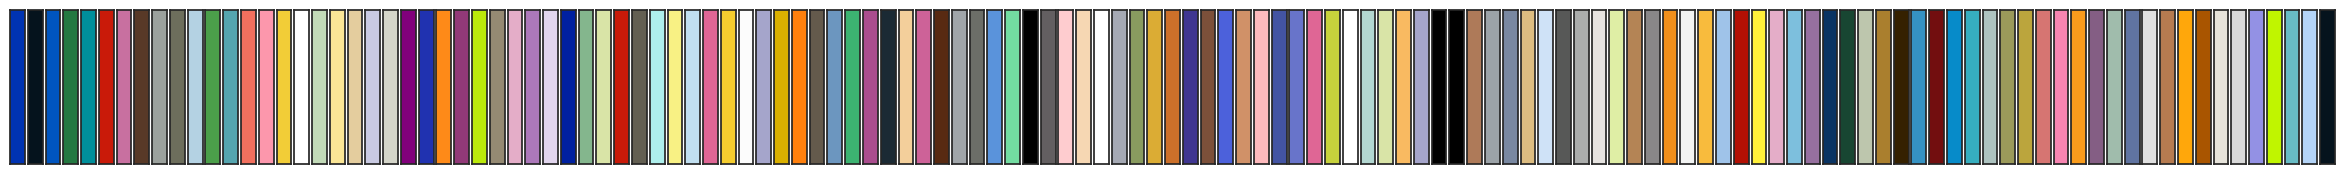

In [39]:
def display_colours(colours):
    # Fig size
    plt.figure(figsize=(30, 2))
    N = colours.shape[0]
    for i,c in enumerate(colours):
        subplot_num = (i + 1) % N if (i + 1) % N != 0 else N
        ax = plt.subplot(1,N,subplot_num)
        ax.set_facecolor(c)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()
# Apply this function to the colors_ref_np array
display_colours(colors_ref_np)

Text(0.5, 0, 'Blue')

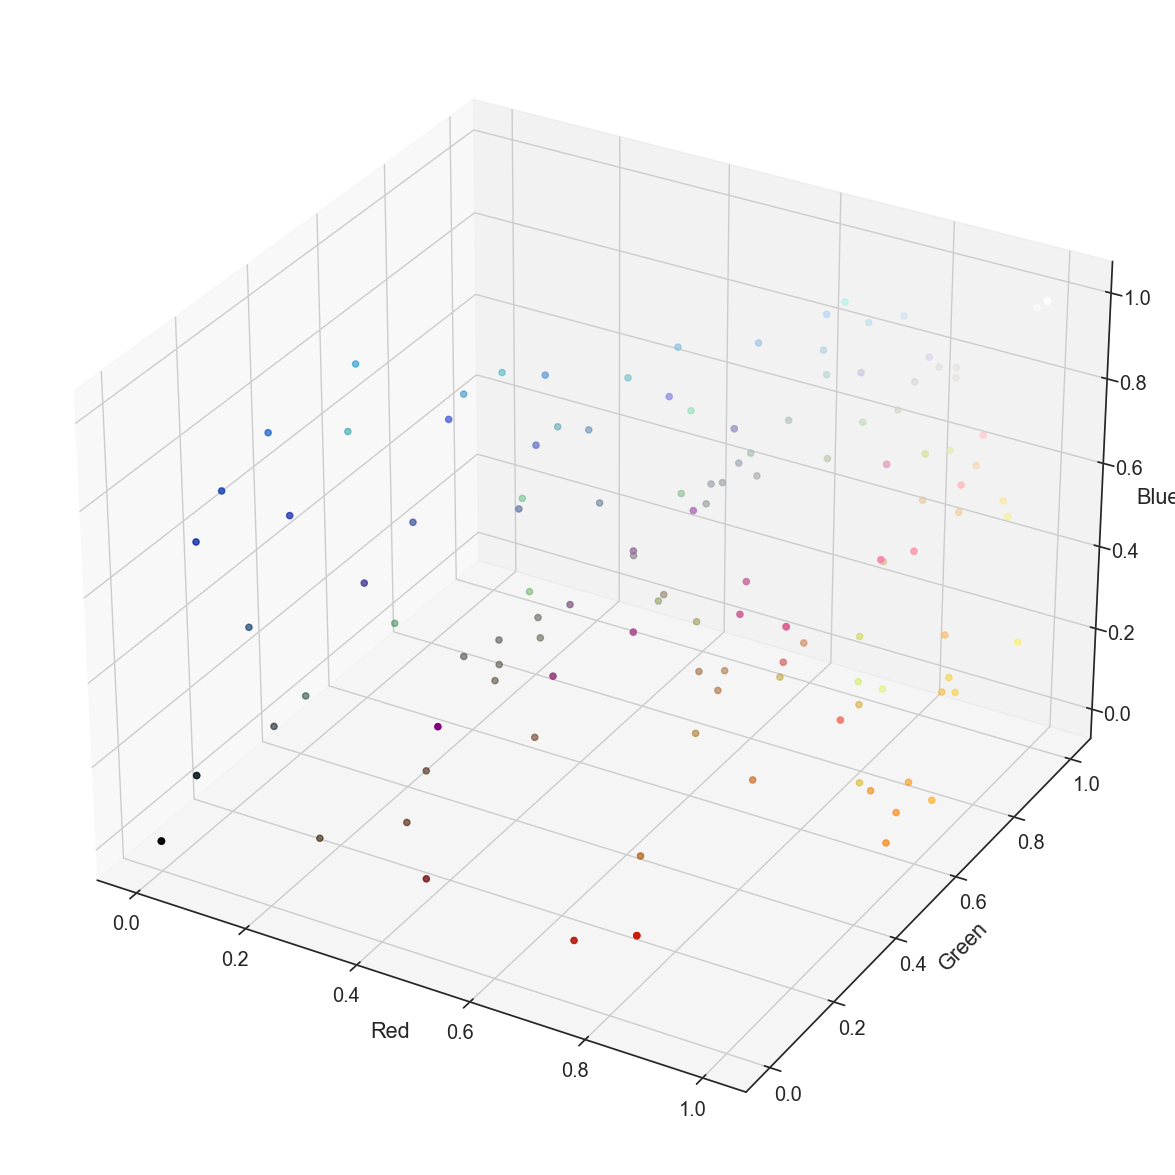

In [36]:
# Plot the colors_ref_np array in 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(colors_ref_np[:,0], colors_ref_np[:,1], colors_ref_np[:,2], c=colors_ref_np)
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

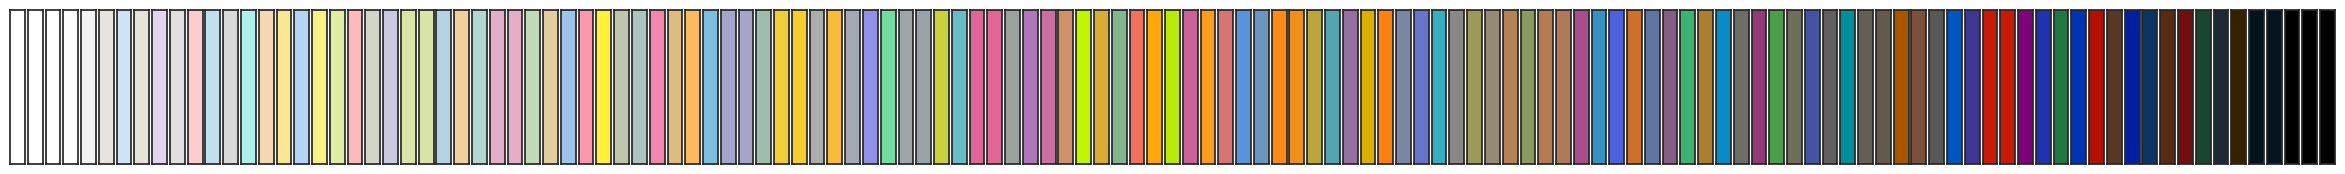

In [43]:
# Find a 1D projection of the colors_ref_np array that reveals groups of colors that have similar characteristics
# Use PCA to find a projection that reveals groups of colors that have similar characteristics.
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
one_d_colours = pca.fit_transform(colors_ref_np)[:,0]
ix = np.argsort(one_d_colours)
display_colours(colors_ref_np[ix])

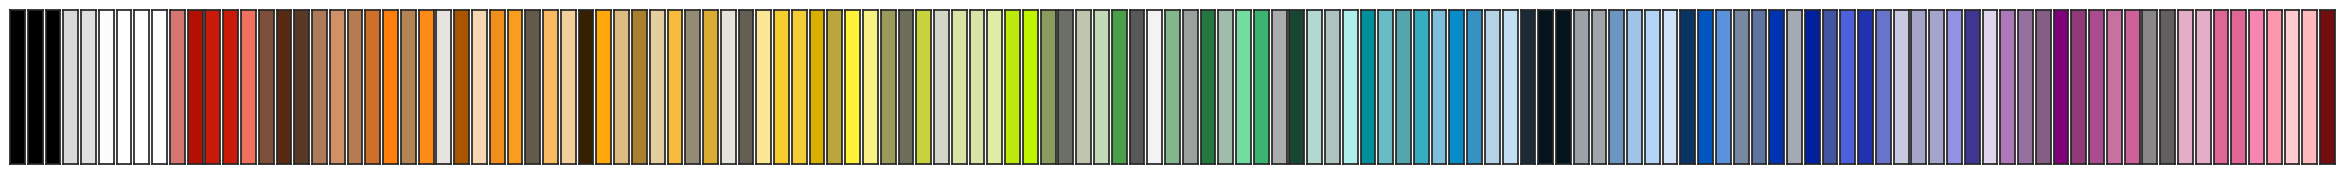

In [49]:
display_colours(colors_ref_np_sorted)

In [ ]:
# 3. Use *k-means* clustering to find groups of colors that have similar characteristics. What set of data columns and what value of k do you think gives the best result?

# Use the lego_colors_vals_only dataframe from above
# Use k-means clustering to find groups of colors that have similar characteristics.
# What set of data columns and what value of k do you think gives the best result?




In [13]:
# 4a. Train and test a kNN classifier to predict the theme for new Lego kits based on the data about them.
#    For each classifier, report:
#        What parameters (if any) you tuned.
#        How well it performed. — Report the Accuracy, Precision, Recall, and F1-score. Also render a confusion matrix. (Remember, don’t test on your training data!)
#        Your interpretation of the result. Explain what you think the classifier got right/wrong. (Feel free to include visualizations or additional info that helps explain).


In [15]:
# Creates a copy of the dataframe where color counts, 'Num Parts' and 'Year' are normalized in lego_colors_by_set
lego_colors_by_set_norm_v2 = lego_colors_by_set.copy()
lego_colors_by_set_norm_v2 = lego_colors_by_set_norm_v2.drop([ 'Set Name', 'Set Num', 'Theme'], axis=1)
# Scale data and convert back to a DataFrame
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
lego_colors_by_set_norm_v2 = pd.DataFrame(scaler.fit_transform(lego_colors_by_set_norm_v2), columns=lego_colors_by_set_norm_v2.columns)
lego_colors_by_set_norm_v2 = pd.concat([lego_colors_by_set_norm_v2,
                                        pd.Series(lego_colors_by_set["Set Name"].array),
                                        pd.Series(lego_colors_by_set["Set Num"].array),
                                        pd.Series(lego_colors_by_set["Theme"].array)], axis=1)
# Rename the last 3 columns
lego_colors_by_set_norm_v2.rename(columns={0: "Set Name", 1: "Set Num", 2: "Theme"}, inplace=True)
lego_colors_by_set_norm_v2.head(3)

,Year,Num Parts,[No Color],Aqua,Black,Blue,Blue-Violet,Bright Green,Bright Light Blue,Bright Light Orange,...,Very Light Bluish Gray,Very Light Gray,Very Light Orange,Violet,White,Yellow,Yellowish Green,Set Name,Set Num,Theme
0,-0.662610,-0.464257,19.229137,-0.043433,-0.404754,-0.341853,0.0,-0.220328,-0.097465,-0.19927,...,-0.020459,-0.020459,0.0,-0.020459,-0.412642,-0.394072,-0.0596,Simple and Motorized Machines Activity Pack,2823692,Technic
1,-0.662610,0.814843,15.988519,-0.043433,0.941350,1.011925,0.0,-0.220328,-0.097465,-0.19927,...,-0.020459,-0.020459,0.0,-0.020459,-0.412642,-0.394072,-0.0596,Structures Set,2818944,Technic
2,-0.914448,0.441900,13.558055,-0.043433,0.662846,-0.293504,0.0,-0.220328,-0.097465,-0.19927,...,-0.020459,-0.020459,0.0,-0.020459,-0.371137,-0.367759,-0.0596,Technology Activity Set,2814926,Technic


Accuracy: 0.636
Precision: 0.626
Recall: 0.636
F1-score: 0.623


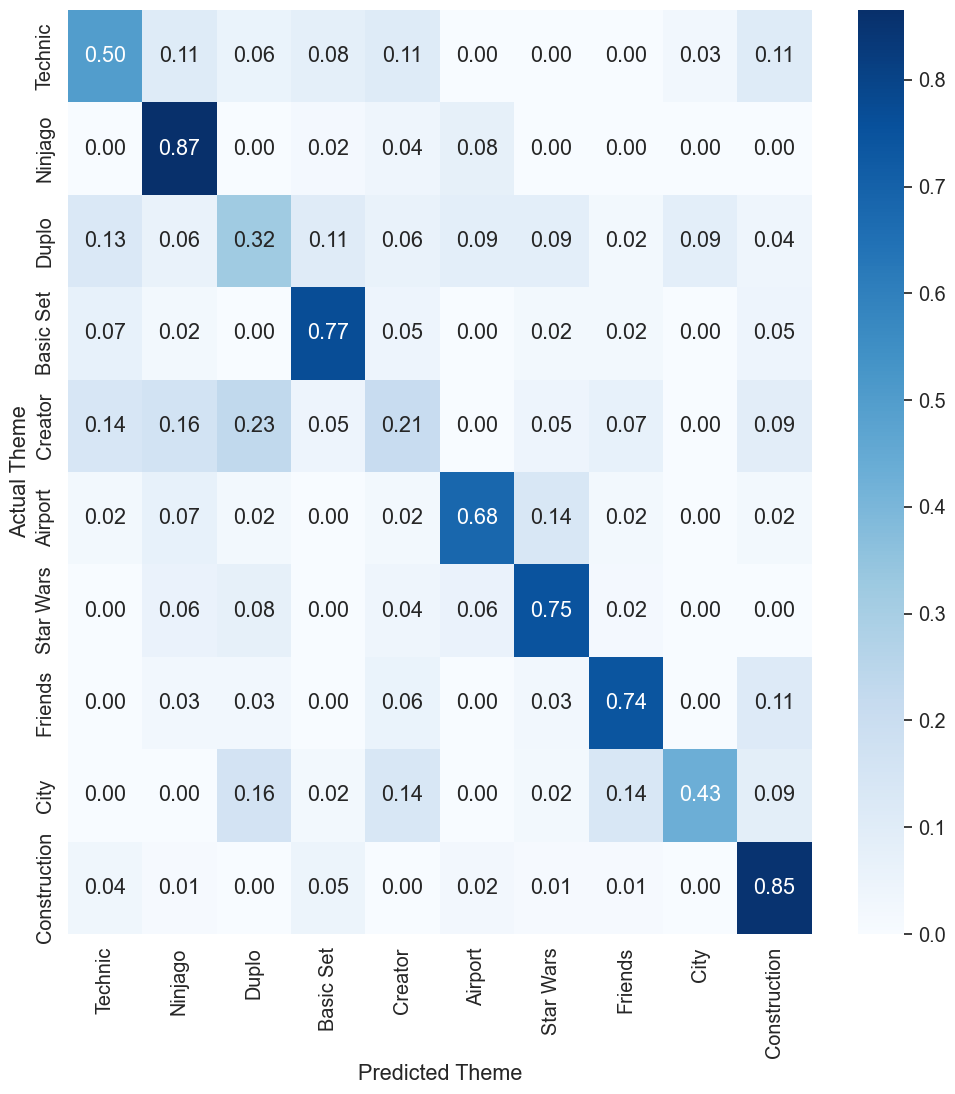

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Select all numerical data for training and testing
# Version 1 - Select all numerical data including 'Year' and 'Num Parts'
# Note that 'Set Num' is not included because it is a string (object)
# lego_colors_by_set_norm_test_and_train = lego_colors_by_set_norm_v2.select_dtypes(include=['float64', 'int64'])
# Version 2 - Select only color as features
lego_colors_by_set_norm_test_and_train = lego_colors_by_set_norm[color_cols]
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(lego_colors_by_set_norm_test_and_train, lego_colors_by_set_norm_v2["Theme"], test_size=0.2, random_state=42)
# Train a kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
# Predict the theme for the test set
y_pred = knn.predict(X_test)
# Report the accuracy, precision, recall, and F1-score for the classifier.
# Round the scores to 3 decimal places
print("Accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.3f}".format(precision_score(y_test, y_pred, average='weighted')))
print("Recall: {:.3f}".format(recall_score(y_test, y_pred, average='weighted')))
print("F1-score: {:.3f}".format(f1_score(y_test, y_pred, average='weighted')))
# Render a confusion matrix
cfmat = skm.confusion_matrix(y_test, y_pred, normalize='true')
# Plot the confusion matrix using seaborn
plt.figure(figsize=(12,12))
sns.heatmap(cfmat, annot=True, fmt=".2f", cmap="Blues", xticklabels=lego_colors_by_set_norm_v2["Theme"].unique(), yticklabels=lego_colors_by_set_norm_v2["Theme"].unique())
plt.xlabel("Predicted Theme")
plt.ylabel("Actual Theme")
plt.show()

In [17]:
# Question 5:
# Use the dimensionality reduction from question 1 to reduce the number of features
# to n, and then use those n features to train a kNN classifier to predict the theme.
# Use the elbow method to find the best value of k.
# Report the accuracy, precision, recall, and F1-score for the classifier.
# Note: If I reduce before, I can make clustering/classification more efficient. Clusters and labels often easier to interpret. The negative is that I lose some information.


In [18]:
# Select all numerical data for training and testing
# Version 1 - Select all numerical data including 'Year' and 'Num Parts'
# lego_colors_by_set_norm_test_and_train = lego_colors_by_set.select_dtypes(include=['float64', 'int64'])
# Version 2 - Select only color as features
lego_colors_by_set_norm_test_and_train = lego_colors_by_set_norm[color_cols]
from sklearn.decomposition import PCA
# Use PCA to reduce the number of colors to n
n = 10
pca = PCA(n_components=n)
principal_components = pca.fit_transform(lego_colors_by_set_norm_test_and_train)
# Stick back into a DataFrame with the original theme labels
df_pca = pd.DataFrame(principal_components)
# Add the theme labels back into the DataFrame
themes = lego_colors_by_set_norm["Theme"].dropna()
df_pca = pd.concat([df_pca, pd.Series(themes.array)], axis=1)
# Rename the columns
df_pca.columns = ['pc' + str(i) for i in range(n)] + ["Theme"]
# Pint head of the new DataFrame
df_pca.head(3)


,pc0,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,Theme
0,0.013635,-0.124780,-0.003893,-0.146667,-0.051285,-0.004427,0.241172,-0.236819,-0.113579,0.819174,Technic
1,0.194544,0.116297,-0.098501,0.153727,-0.137323,0.056577,0.007784,-0.008049,-0.002403,0.030592,Technic
2,0.380027,0.176789,-0.041287,0.123676,-0.087163,-0.041056,-0.001954,-0.013628,-0.005248,0.037243,Technic


In [19]:
# Putting component values into a dataframe + adding labels improves readability
components = pd.DataFrame(pca.components_)
# Column names are the original features
components.columns = lego_colors_by_set_norm_test_and_train.columns # color_cols
components

,[No Color],Aqua,Black,Blue,Blue-Violet,Bright Green,Bright Light Blue,Bright Light Orange,Bright Light Yellow,Bright Pink,...,Trans-Very Lt Blue,Trans-Yellow,Unknown,Very Light Bluish Gray,Very Light Gray,Very Light Orange,Violet,White,Yellow,Yellowish Green
0,-0.001699,-0.000021,-0.214146,-0.052211,-4.484424e-24,-0.006025,-0.000597,-0.004621,-0.000463,-0.004180,...,-0.000001,-0.004152,0.000733,-0.000019,-3.307560e-07,-0.0,0.000183,-0.140879,-0.082168,-0.000576
1,-0.018662,-0.000087,0.923550,-0.083011,-1.363713e-21,-0.024965,-0.003631,-0.021027,-0.003249,-0.022135,...,-0.000019,-0.004287,-0.000977,-0.000030,-2.132435e-06,-0.0,0.000176,-0.263882,-0.050401,0.000302
2,-0.000508,-0.000118,0.062849,-0.165876,3.418252e-19,-0.022662,0.003379,0.010155,0.000736,0.022236,...,0.000028,0.005826,0.002036,0.000083,-2.171628e-06,-0.0,0.000028,0.681093,-0.572285,0.001433
3,-0.035002,-0.000010,0.231609,0.083791,-8.759782e-19,-0.006284,-0.001935,-0.008618,-0.001337,-0.010378,...,-0.000013,-0.010428,-0.001394,0.000024,-5.444423e-07,-0.0,0.000014,0.416135,-0.068079,-0.001373
4,-0.015444,-0.000071,0.039841,-0.057260,-3.519103e-18,-0.012699,0.001223,-0.003773,-0.002100,0.004817,...,0.000009,0.002512,0.000453,0.000156,2.169531e-07,-0.0,-0.000021,0.381034,0.726771,-0.000732
5,-0.003048,0.000256,0.011689,0.941902,5.214833e-17,-0.009211,-0.000423,-0.014054,-0.002614,-0.016984,...,-0.000005,-0.003585,-0.000509,-0.000030,3.257738e-06,0.0,0.000098,-0.013039,-0.142152,-0.000431
6,0.124205,-0.000053,-0.043901,-0.119477,2.270825e-16,0.051640,0.006662,0.048021,0.007989,0.050150,...,0.000051,0.017400,0.004799,0.000004,3.171081e-06,-0.0,0.000145,-0.239620,-0.247270,0.002368
7,-0.177606,-0.000072,0.051120,0.053188,7.912602e-17,-0.051256,-0.006665,-0.042381,-0.008291,-0.043392,...,-0.000047,0.035107,-0.004347,-0.000030,-1.040248e-06,0.0,-0.000091,0.107187,0.060939,-0.003203
8,-0.091217,0.000046,0.016797,0.033641,5.363319e-17,-0.034073,-0.005104,-0.037662,-0.005449,-0.046009,...,-0.000026,-0.011871,-0.000926,0.000001,4.201478e-07,0.0,-0.000052,0.060189,0.014446,-0.000473
9,0.778573,0.000039,-0.040778,-0.074160,1.841779e-17,0.003795,0.004551,0.005354,0.003142,0.004576,...,0.000040,0.001606,0.004343,0.000041,-1.806547e-06,-0.0,0.000103,-0.043175,-0.054902,0.000157


<AxesSubplot: xlabel='PC', ylabel='var'>

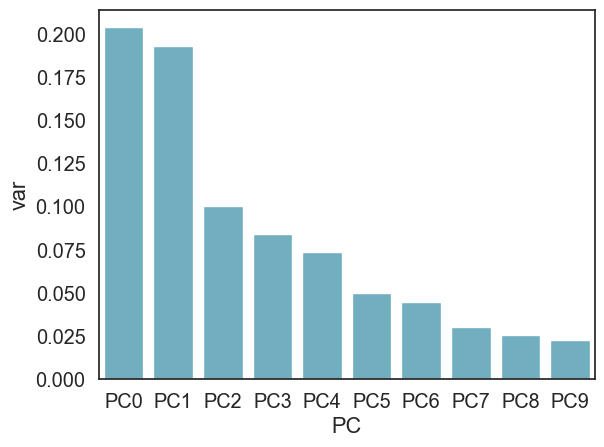

In [20]:
# Scree plot using Seaborn
# Create a new dataframe with explained variance vals for each PC
df_pca_explained_variance = pd.DataFrame({'var': pca.explained_variance_ratio_, 'PC': ['PC' + str(i) for i in range(pca.n_components_)]})
sns.barplot(x='PC', y="var", data=df_pca_explained_variance, color="c")


In [21]:
# Sum of explained variance
pca.explained_variance_ratio_.sum()

0.827588876918183

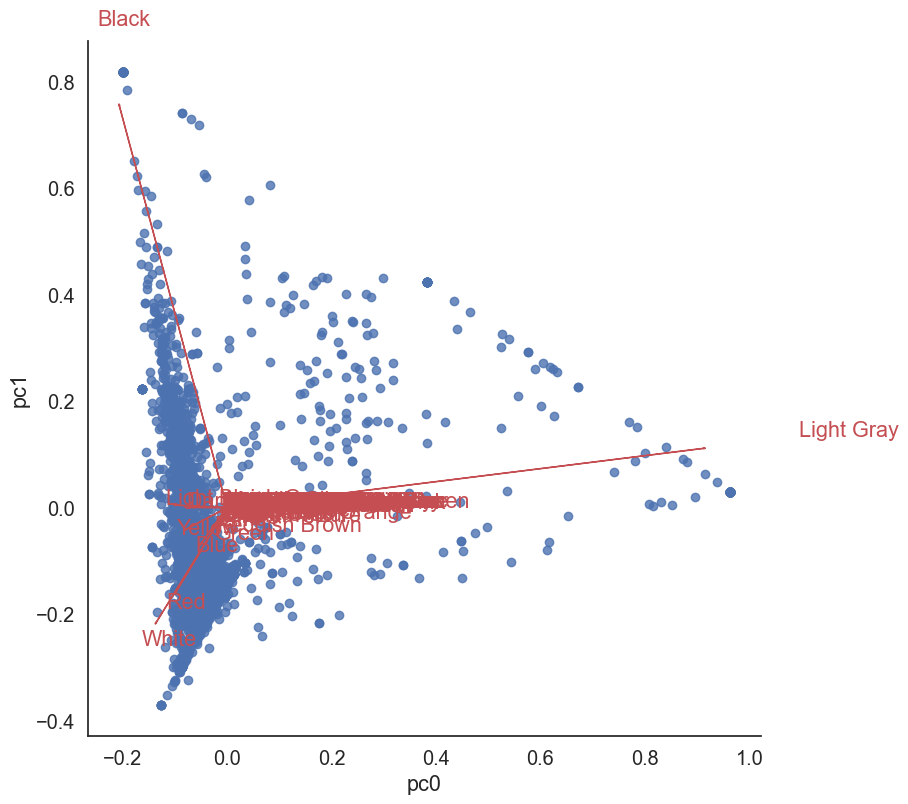

In [22]:
# Plot using the PCA components as the x and y axes
sns.lmplot(data=df_pca, x='pc0', y='pc1', fit_reg=False, height=8)
# set the maximum variance of the first two PCs
# this will be the end point of the arrow of each **original feature**
xvector = pca.components_[0]
yvector = pca.components_[1]

# value of the first two PCs, set the x, y axis boundary
xs = df_pca['pc0'] # xs = pca.transform(lego_colors_by_set_norm[color_cols])[:,0]
ys = df_pca['pc1'] # ys = pca.transform(lego_colors_by_set_norm[color_cols])[:,1]
# arrows project features (columns from csv) as vectors onto PC axes
# we can adjust length and make it look nicer
for i in range(len(xvector)):
    # arrows project features (ie columns from csv) as vectors onto PC axes
    # we can adjust length and make it look nicer
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys), color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2, list(lego_colors_by_set_norm_test_and_train)[i], color='r')

In [31]:
# Check loadings for each component
loading_scores = pd.Series(pca.components_[0], index=lego_colors_by_set_norm_test_and_train.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_10_colors = sorted_loading_scores[0:10].index.values
print(loading_scores[top_10_colors])

Light Gray           0.947512
Black               -0.214146
White               -0.140879
Light Bluish Gray   -0.101783
Red                 -0.100811
Yellow              -0.082168
Dark Bluish Gray    -0.065604
Blue                -0.052211
Reddish Brown       -0.019983
Green               -0.019642
dtype: float64


In [28]:
# Join the loadings for all components into a single dataframe
loading_scores = pd.DataFrame(pca.components_, columns=lego_colors_by_set_norm_test_and_train.columns)
# Total of all columns
loading_scores['total'] = loading_scores.sum(axis=1)
loading_scores['total1'] = loading_scores.sum(axis=0)


# Abs the loadings
# loading_scores = loading_scores.abs()



Accuracy:  0.605
Precision:  0.594
Recall:  0.605
F1-score:  0.594


<AxesSubplot: >

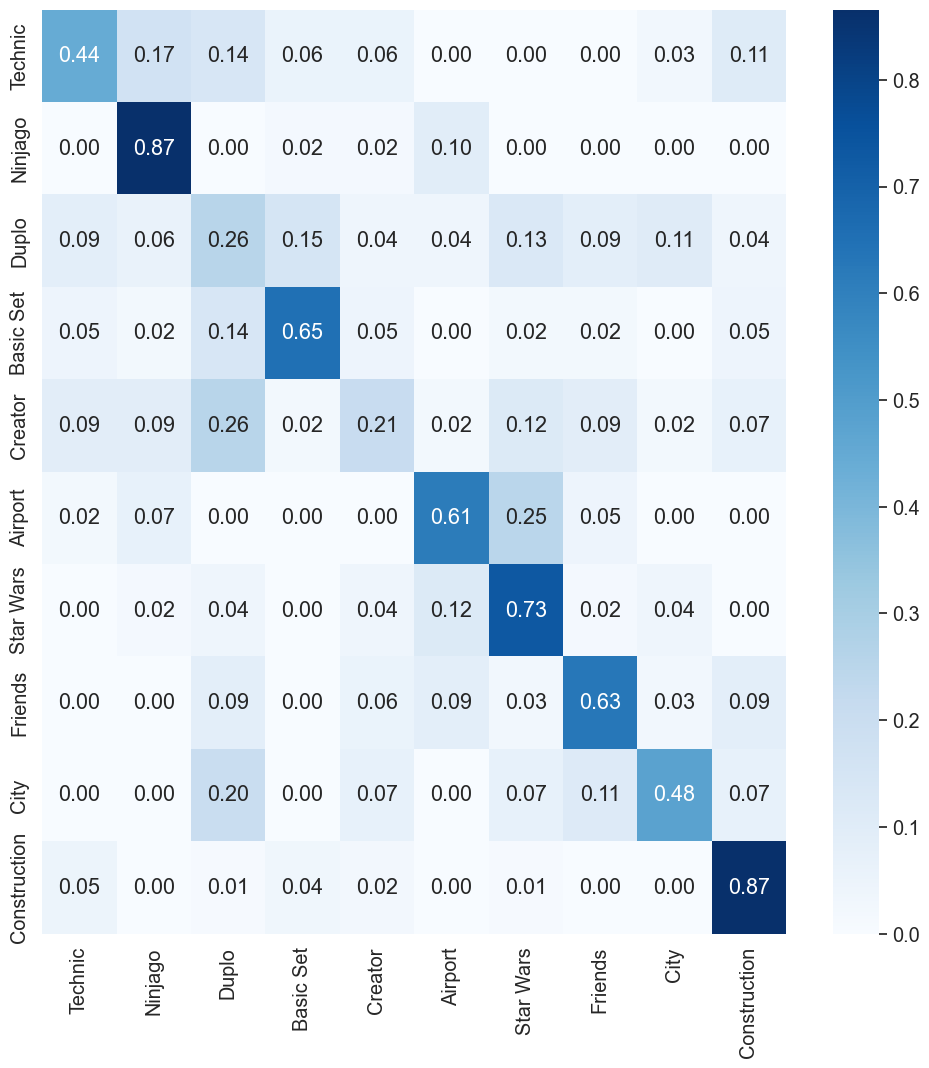

In [24]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_pca[['pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9']], df_pca["Theme"], test_size=0.2, random_state=42)
# Train a kNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
# Predict the theme for the test set
y_pred = knn.predict(X_test)
# Report the accuracy, precision, recall, and F1-score for the classifier.
# Round the scores to 3 decimal places
print("Accuracy: ", round(skm.accuracy_score(y_test, y_pred), 3))
print("Precision: ", round(skm.precision_score(y_test, y_pred, average='weighted'), 3))
print("Recall: ", round(skm.recall_score(y_test, y_pred, average='weighted'), 3))
print("F1-score: ", round(skm.f1_score(y_test, y_pred, average='weighted'), 3))
# Render a confusion matrix
cfmat = skm.confusion_matrix(y_test, y_pred, normalize='true')
# Plot the confusion matrix using seaborn
plt.figure(figsize=(12,12))
sns.heatmap(cfmat, annot=True, fmt=".2f", cmap="Blues", xticklabels=lego_colors_by_set_norm["Theme"].unique(), yticklabels=lego_colors_by_set_norm["Theme"].unique())

Text(0, 0.5, 'Testing Accuracy')

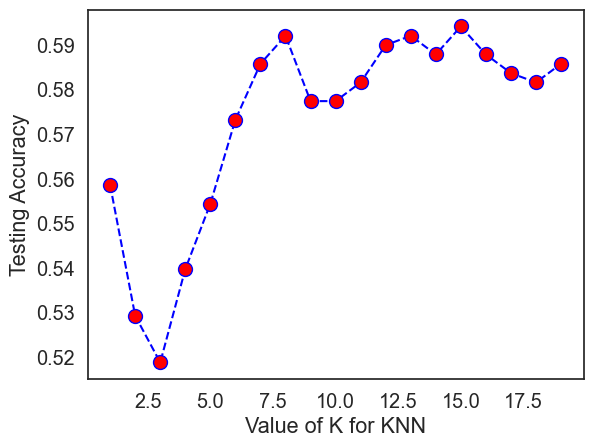

In [148]:
# Improve the model by finding the optimal value for k
# Plot the accuracy for different values of k
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(skm.accuracy_score(y_test, y_pred))
plt.plot(k_range, scores, color = 'blue',linestyle='dashed',
         marker='o',markerfacecolor='red', markersize=10)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

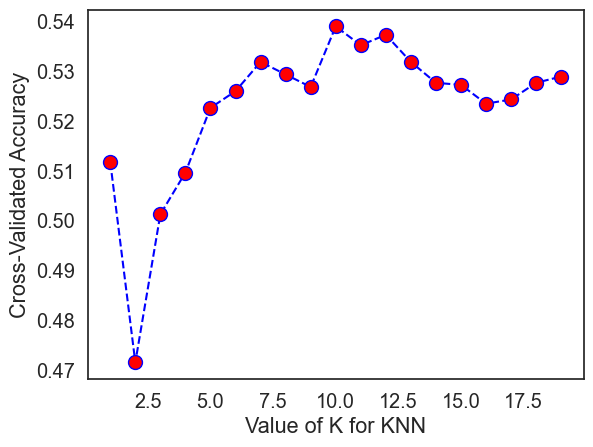

In [153]:
# Train knn with cross validation
from sklearn.model_selection import cross_val_score
k_range = range(1, 20)
k_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, df_pca[['pc0', 'pc1', 'pc2', 'pc3', 'pc4']], df_pca["Theme"], cv=10, scoring='accuracy')
    k_scores.append(scores.mean())

# plot to see clearly
plt.plot(k_range, k_scores, color = 'blue',linestyle='dashed',
         marker='o',markerfacecolor='red', markersize=10)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

**Conclusion:** The KNN algorithm with basic parameters and colors as features was producing score metrics around 63%. Definitely, the number of 131 colours is too much and there are many similar colours. The PCA analysis helped to reduce the number of features to 10 principal components (explain 87% of variance) by sacrificing 3%-4% of accuracy. That is a reasonable price in the sake of simplifying the model ( reducing the number of explanatory variables). The main colors that help to distinguish the themes are: light grey, black, white, red and yellow.
By optimizing the number of neighbours for the KNN algorithm with the help of cross-validation the metrics bounced back to initial results. The 63% is not a great result, but it is a good starting point for further improvements. Though, the model can predict such Themes as 'Ninjago', 'Star Wars' or 'Construction' with accuracy more than 80%. Mostly because these themes are very distinctive and have a lot of unique colours. The model is not able to distinguish between 'City', 'Creator', 'Technic' because these themes have a lot of similar colours.


In [ ]:
# 4b. Train and test a Naive Bayes classifier to predict the theme for new Lego kits based on the data about them.
#    For each classifier, report:
#        What parameters (if any) you tuned.
#        How well it performed. — Report the Accuracy, Precision, Recall, and F1-score. Also render a confusion matrix. (Remember, don’t test on your training data!)
#        Your interpretation of the result. Explain what you think the classifier got right/wrong. (Feel free to include visualizations or additional info that helps explain).

Accuracy:  0.4372384937238494
Precision:  0.4707612186513256
Recall:  0.4372384937238494
F1-score:  0.4019522160291403


<AxesSubplot: >

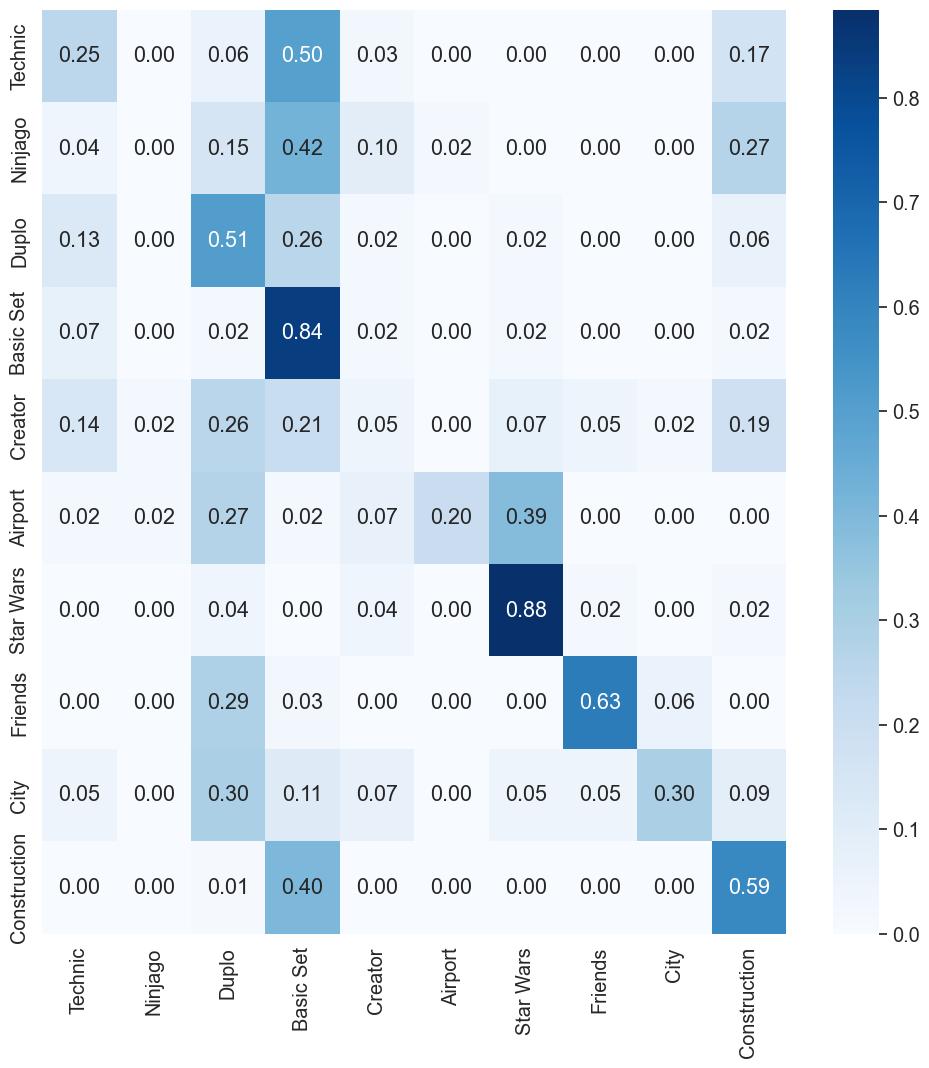

In [87]:
from sklearn.naive_bayes import GaussianNB
# Train a Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)
# Predict the theme for the test set
y_pred = gnb.predict(X_test)
# Report the accuracy, precision, recall, and F1-score for the classifier.
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred, average="weighted"))
print("Recall: ", recall_score(y_test, y_pred, average="weighted"))
print("F1-score: ", f1_score(y_test, y_pred, average="weighted"))
# Render a confusion matrix
cfmat = skm.confusion_matrix(y_test, y_pred, normalize='true')
# Plot the confusion matrix using seaborn
plt.figure(figsize=(12,12))
sns.heatmap(cfmat, annot=True, fmt=".2f", cmap="Blues", xticklabels=lego_colors_by_set_norm["Theme"].unique(), yticklabels=lego_colors_by_set_norm["Theme"].unique())
